In [ ]:
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
import time

In [ ]:
def init_grid(len, height):
  dx,dy = 1
  grid = np.zeros([int(len/dx),int(height/dy)])

  return grid

In [ ]:
def init_cond(len,height):
  dx,dy = 1
  grid_cond = np.ones([int(len/dx),int(height/dy)], dtype = bool)
  
  return grid_cond

In [ ]:
def sweep(grid, frame, W, constant):
  stencil = np.array([[0,1,0],[1,-4,1], [0,1,0]])
  output = np.zeros_like(grid)
  len, height = grid.shape
  # Bounded diagonal Matrix settings for both black and white for checkeredboard pattern.
  M_black = np.zeros(grid.shape, dtype = bool)
  M_black[::2, ::2] = True
  M_black[1::2, 1::2] = True
  frame_black = M_black * frame

  M_white = np.ones(grid.shape, dtype = bool)
  M_white[::2, ::2] = False
  M_white[1::2, 1::2] = False
  frame_white = M_white * frame

  # Convolve.
  
  # Black
  grid[frame_black] += (W/4) * ndimage.convolve(grid, stencil, output = output, mode = 'constant', cval = 0)[frame_black] + constant

  # White 
  grid[frame_white] += (W/4) * ndimage.convolve(grid, stencil, output = output, mode = 'constant', cval = 0)[frame_white] + constant

  return grid

In [ ]:
# Layer Grids to solve.
def fine_grid(grid, grid2, x1, x2, y1, y2, pot):
  #Extract smaller grid points from the grid initialized.
  len, height = grid.shape
  x1_g = int(x1*len)
  x2_g = int(x2*len)
  y1_g = int(y1*height)
  y2_g = int(y2*height)

  # -- 

  dx = x2_g - x1_g
  dy = y2_g - y1_g

  if dx == 0:
    m = 0
  else:
    m = dy/dx


  # Potential
  for i in range(len):
    if x2_g >= i and i >= x1_g:
      for jj in range(height):
        if jj == int(m * i + (y1_g - m * x1_g)) and y2_g >= jj and jj >= y1_g:
          grid[jj,i] = pot
          grid2[jj,i] = False
  return grid, grid2







  



In [ ]:
def restriction(grid,iter):
  # iter parameter decides how many times restriction is being applied.
  for i in range(iter):
    stencil = (1/4) * np.array([[1/4, 1/2, 1/4],[1/2, 1, 1/2], [1/4, 1/2, 1/4]])
    grid = ndimage.convolve(grid, stencil, mode = 'constant', cval = 0)
    coarse = grid[::2,::2]
    coarse = 0.5 * coarse

  return coarse

In [ ]:
def prolongation(grid,iter):
  for i in range(iter):
    stencil = (1/4) * np.array([[1/4, 1/2, 1/4],[1/2, 1, 1/2], [1/4, 1/2, 1/4]])
    grid = ndimage.convolve(grid, stencil, mode = 'constant', cval = 0)

    len, height = grid.shape

    prolonged = np.zeros([len+1,height+1])
    len2, height2 = prolonged.shape

    if prolonged.shape[0] % 2 != 0:
      midpoint = int((prolonged.shape[0] -1) / 2)
      prolonged[midpoint:] = 1000

    else:
      prolonged = np.zeros([len+2, height+2])
      midpoint = int((prolonged.shape[0] -1) / 2)
      prolonged[midpoint:] = 1000

  return prolongation

In [ ]:
# 0 <= W <= 2 is SOR. Closer to 2.


W = 1
init_grid = np.zeros([100,100])
init_cond = np.ones([100,100], dtype = bool)

init_grid, boundries = fine_grid(init_grid, init_cond, 0.1,0.9,0.5,0.6,1500)


# First iterate couple times to prevent having 0 values at each point

start = time.time()
for i in range(5000):
  init_grid = sweep(init_grid, boundries, W, 0)
end = time.time()

# restriction(init_grid,2)
# prolongation(init_grid,2)

print(f'Without coarsening: {end-start} seconds.')

  





Without coarsening: 3.277946710586548 seconds.


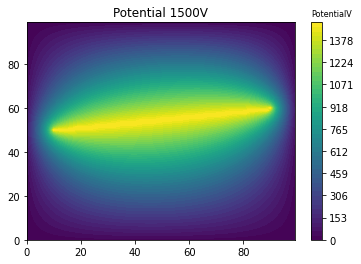

In [ ]:
plt.figure()
plt.title("Potential 1500V")
levels = np.linspace(0, 1500, 50)
cbar = plt.colorbar(plt.contourf(init_grid, levels=levels))
cbar.ax.set_title("PotentialV", fontsize=8, loc="left")
plt.savefig('Potential_1500V.png')

For a 100x100 matrix,
  Without coarsening: 3.2918503284454346 seconds.
  With coarsening: 0.05912470817565918 seconds.


For a 1000x1000 matrix,
  Without coarsening: 63.00090408325195 seconds.
  With coarsening: 12.838725566864014 seconds.